In [1]:
# This code is written by Yara Al-Shorman
# Date created: May 18 2022
# Last modified: Jun 6 2022
# Github repo: https://github.com/YaraAlShorman/Research-spring-22
# The purpose of this code is to predict the bulkflows for a large given set of galaxies (using machine learning)

### imports

In [2]:
# imports
import tensorflow as tf
from numpy import load, concatenate, expand_dims  # I am doing this to minimize unncessary imports, they take up too much RAM and time
from sklearn.preprocessing import MinMaxScaler
from math import floor
from matplotlib import pyplot as plt

In [3]:
# # run this snippet to disable GPU

# import os

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# if tf.test.gpu_device_name():
#     print('GPU found')
# else:
#     print("No GPU found")

### checking for GPU

### tangent: running tensorflow with GPU

Tensorflow by default attempts to run on GPU if possible. If the capability to do so was not found, it runs on the CPU. <br>
To allow it to run on the GPU and you are using an NVIDIA graphics card, you must download the THE CORRECT VERSIONS of CUDNN, CUDA, Tensorflow, and Python. <br>
Yes, all of them have to match up. (It took me 2 days to figure that out) <br>
To check if your NVIDIA GPU is compatible (I dont know if this works for AMD GPUs): Refer to https://developer.nvidia.com/cuda-gpus <br>
I have a GTX 1650 TI with Max-Q capability. Which is compatible.<br>
Furthermore, you must ensure you have matching versions of Python, Tensorflow, CUDNN and CUDA. <br>
No, having the newest versions is not enough. <br>
I installed: <br>
CUDNN v11.2 <br>
CUDA v8.1 <br>
Tensorflow v2.9 <br>
Python v3.10 <br>
You also need a compatible version of Visual Studio (MSVC). I have MSVC 2019. <br>
Keep in mind that the newest versions of CUDA and CUDNN are 8.4 and 11.7, respectively. Which will NOT work. Pay careful attention to versions. <br>
Refer to this page for compatible versions: https://www.tensorflow.org/install/source_windows#gpu <br>
Of course, things are different if you are using Mac or Linux <br>

In [4]:
# checking that GPU is available
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# to avoid memory allocation/resource errors with my GPU
# this prevents Tensorflow from allocating all the memory at once, and instead
# allocating it as necessary
# such that it doesn't exhaust the entire 4 GB of memory from the GPU

gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus: tf.config.experimental.set_memory_growth(gpu, True)

### data preprocessing

In [6]:
# stacking all of the data into one humungous tensor
# I am using tensors because they can be ragged and can be stacked
# these means we won't have to cut off our data to standardize array sizes
# data = load(f'C:/Users/yaras/Documents/Research/Feldman/rotated-outerrim-cz-rand/rotated-0-error-40.npy.npz')
data = load(f'C:/Users/yaras/Documents/Research/Feldman/TEST/rotated-0-TEST.npz')
input_data = data['data']
scaler = MinMaxScaler()
scaler.fit(input_data)
input_data = scaler.transform(input_data)
input_data = tf.expand_dims(input_data, axis=0)
input_data = tf.RaggedTensor.from_tensor(input_data)
# if scaling the data this way doesn't work good enough, i can try scaling all the data at once, to one scale
# in this case, i am scaling every 'square' of data seprately
# i should try scaling the entire 'cube' at once

output_data = tf.convert_to_tensor(data['header'])
output_data = tf.expand_dims(output_data, axis=0)

num_of_files = 100  # variable for number of files to load, current limit is 3000
files_acc = range(10, num_of_files)

for i in files_acc: # limit 3000
        # array_data = load(f'C:/Users/yaras/Documents/Research/Feldman/rotated-outerrim-cz-rand/rotated-{i}-error-40.npy.npz')
        array_data = load(f'C:/Users/yaras/Documents/Research/Feldman/TEST/rotated-{i}-TEST.npz')
        # 'data' data
        temp = tf.convert_to_tensor(array_data['data'], dtype='float64')
        scaler = MinMaxScaler()
        scaler.fit(temp)
        temp = scaler.transform(temp)
        temp = tf.expand_dims(temp, axis=0)  # dimensions have to be expandad to be able to concat along the outer-dimension 
        input_data = tf.concat([input_data, temp], axis=0)  # concat adds to existing dimensions, does not create new ones
        # 'input_data' is a tensor
        
        # 'header' data (bulkflows)
        temp = array_data['header']
        temp = expand_dims(temp, axis=0)
        output_data = concatenate([output_data, temp], axis=0)
        # 'output_data' is an array, because it is uniform 
        # i scale it (normalize it) all at once, then i convert it to a tensor
        
# next is scaling

In [7]:
# normalizing/scaling the data
scaler = MinMaxScaler()
scaler.fit(output_data)
output_data = scaler.transform(output_data)
output_data = tf.convert_to_tensor(output_data)

In [8]:
# splitting the data into train/test sections
# 75% -> train
# 25% -> test
train_percent = 0.75
cuttoff = len(files_acc) * train_percent
input_train, input_test = (input_data[:floor(cuttoff)], \
                                input_data[floor(cuttoff)::])
output_train, output_test = (output_data[:floor(cuttoff)], \
                                output_data[floor(cuttoff)::])

# data is split and ready for the model

In [9]:
input_test.shape

TensorShape([24, None, 4])

### model creation

In [10]:
# optimizer
# 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-05)
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.00001)

In [11]:
# model creation

model0 = tf.keras.Sequential()
model0.add(tf.keras.layers.InputLayer(input_shape=[None, 4], ragged=True, batch_size=64))
model0.add(tf.keras.layers.LSTM(32, activation='tanh'))  # tanh is necessary to make GPU accelaration work
model0.add(tf.keras.layers.Dense(16, activation='tanh'))
# model0.add(tf.keras.layers.Dropout(0.3))
model0.add(tf.keras.layers.Dense(8, activation='tanh'))
# model0.add(tf.keras.layers.Dropout(0.3))
model0.add(tf.keras.layers.Dense(4, activation='relu'))
# model0.add(tf.keras.layers.Dropout(0.3))
# model0.add(tf.keras.layers.Dense(16, activation='relu'))
# model0.add(tf.keras.layers.Dropout(0.3))
model0.add(tf.keras.layers.Dense(3, activation='linear'))

model0.compile(loss='mean_squared_logarithmic_error', optimizer=optimizer, metrics=['accuracy'])

In [12]:
model0.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (64, 32)                  4736      
                                                                 
 dense (Dense)               (64, 16)                  528       
                                                                 
 dense_1 (Dense)             (64, 8)                   136       
                                                                 
 dense_2 (Dense)             (64, 4)                   36        
                                                                 
 dense_3 (Dense)             (64, 3)                   15        
                                                                 
Total params: 5,451
Trainable params: 5,451
Non-trainable params: 0
_________________________________________________________________


In [13]:
a = model0.fit(input_train, output_train, epochs=20, use_multiprocessing=True, workers=1000)

Epoch 1/20
3/3 [==============================] - 6s 292ms/step - loss: 0.1760 - accuracy: 0.2687
Epoch 2/20
3/3 [==============================] - 1s 272ms/step - loss: 0.1751 - accuracy: 0.2687
Epoch 3/20
3/3 [==============================] - 1s 268ms/step - loss: 0.1741 - accuracy: 0.2687
Epoch 4/20
3/3 [==============================] - 1s 265ms/step - loss: 0.1731 - accuracy: 0.2687
Epoch 5/20
3/3 [==============================] - 1s 300ms/step - loss: 0.1721 - accuracy: 0.2687
Epoch 6/20
3/3 [==============================] - 1s 279ms/step - loss: 0.1711 - accuracy: 0.2687
Epoch 7/20
3/3 [==============================] - 1s 282ms/step - loss: 0.1700 - accuracy: 0.2687
Epoch 8/20
3/3 [==============================] - 1s 276ms/step - loss: 0.1689 - accuracy: 0.2687
Epoch 9/20
3/3 [==============================] - 1s 270ms/step - loss: 0.1677 - accuracy: 0.2687
Epoch 10/20
3/3 [==============================] - 1s 273ms/step - loss: 0.1665 - accuracy: 0.2687
Epoch 11/20
3/3 [==

### testing & graphing results

In [14]:
output_pred = model0.predict(input_test)

1/1 [==============================] - 0s 459ms/step


In [15]:
# recall that scaler = MinMaxScaler(), it uses the same transformer I used to scale the data initally to un-scale it
output_pred = scaler.inverse_transform(output_pred)
output_test = scaler.inverse_transform(output_test)

In [16]:
# producing tensors of the true/predicted magnitues of the bulkflow
# basically pythagorean theorem
# magnitude = sqrt(x^2 + y^2 + z^2)

bf = tf.math.sqrt(tf.math.pow(output_test[:, 0], 2) + tf.math.pow(output_test[:, 1], 2) + tf.math.pow(output_test[:, 2], 2))
pred_bf = tf.math.sqrt(tf.math.pow(output_pred[:, 0], 2) + tf.math.pow(output_pred[:, 1], 2) + tf.math.pow(output_pred[:, 2], 2))

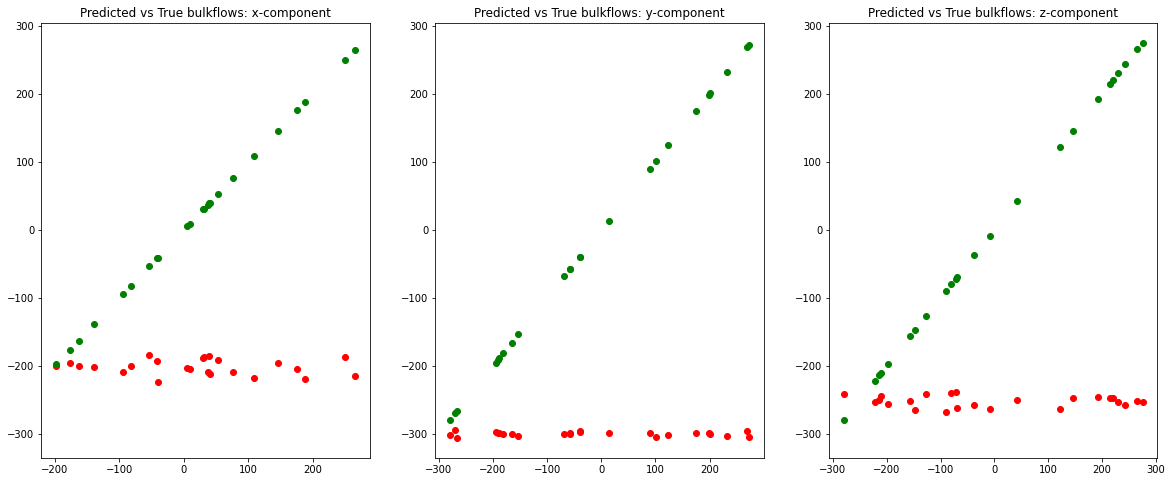

In [17]:
# GREEN is TRUE
# RED is PREDICTED

fig = plt.figure()
fig.set_figheight(8) 
fig.set_figwidth(20)

bx = fig.add_subplot(1, 3, 1)
plt.scatter(output_test[:, 0], output_pred[:, 0], color='red')
plt.scatter(output_test[:, 0], output_test[:, 0], color='green')
plt.title('Predicted vs True bulkflows: x-component')


by = fig.add_subplot(1, 3, 2, sharey=bx)
plt.scatter(output_test[:, 1], output_pred[:, 1], color='red')
plt.scatter(output_test[:, 1], output_test[:, 1], color='green')
plt.title('Predicted vs True bulkflows: y-component')

bz = fig.add_subplot(1, 3, 3, sharey=bx)
plt.scatter(output_test[:, 2], output_pred[:, 2], color='red')
plt.scatter(output_test[:, 2], output_test[:, 2], color='green')
plt.title('Predicted vs True bulkflows: z-component')

plt.show()

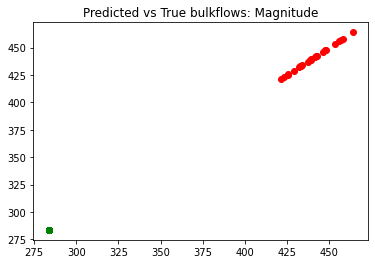

In [18]:
fig1 = plt.figure()
bx = fig1.add_subplot(1, 1, 1)
plt.scatter(bf, bf, color='green')
plt.scatter(pred_bf, pred_bf, color='red')
plt.title('Predicted vs True bulkflows: Magnitude')

plt.show()
